# Seismic modelling

In this third lab of the *ErSE 210 - Seismology* course, we will look at seismic modelling. More specifically, we will perform:

- the simplest approach to modelling of seismic data, the so-called *1D convolutional model*;
- AVO modelling by means of the Zoeppritz equation and a couple of famous linearizations;
- Basic inversion of pre-stack seismic data.

For the AVO modelling and inversion we will leverage the Python library [PyLops](http://github.com/pyLops/pylops) for matrix-free linear algebra and optimization. Feel free to look at how these algorithms have been implemented or implement your own simple inversion routines.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import lasio

from scipy.signal import medfilt, filtfilt
from pylops.utils.wavelets import ricker
from pylops.avo.avo import zoeppritz_pp, akirichards, fatti
from pylops.avo.prestack import PrestackLinearModelling
from pylops.optimization.leastsquares import NormalEquationsInversion

np.random.seed(0)

## 1D convolutional modelling

Let's start with defining the equation underlying the *1D convolutional modelling*:

$$
d(t, \theta=0) =  w(t) * \frac{AI(t)-AI(t-1)}{AI(t)+AI(t-1)}
$$

This is simple to code up as you will see, but we need to start by creating a synthetic profile of acoustic impedance ($AI(t)$) and a wavelet ($w(t)$). Since we will later turn our attention to modelling of pre-stack seismic data, let's already create triplet of elastic parameters $(V_P, V_S, \rho)$.

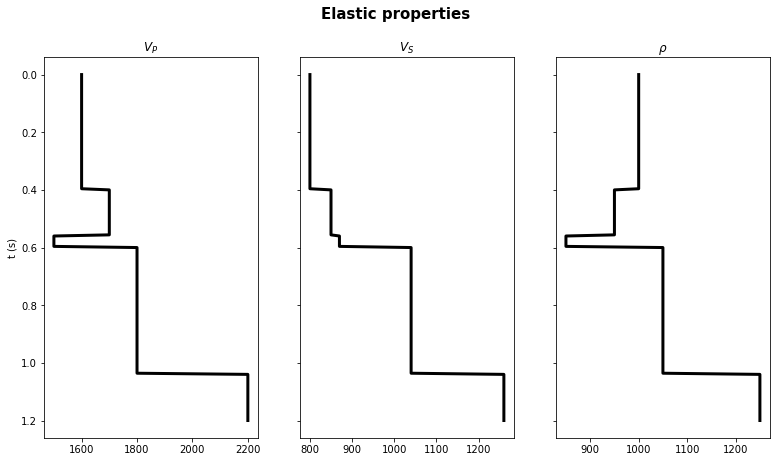

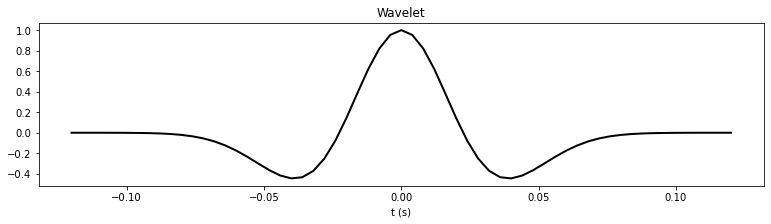

In [2]:
# Time axis
nt = 301
dt = 0.004
t  = np.arange(nt) * dt

# Velocity and density profiles
vp0 = 1600
vs0 = 800
rho0 = 1000
vpchanges = [100, -200, 300, 400]
vschanges = [50, 20, 170, 220]
rhochanges = [-50, -100, 200, 200]
tchanges = [100, 140, 150, 260]

vp = vp0 * np.ones(nt)
vs = vs0  * np.ones(nt)
rho = rho0 * np.ones(nt)
    
for vpchange, vschange, rhochange, tchange in zip(vpchanges, vschanges, rhochanges, tchanges):
    vp[tchange:] += vpchange
    vs[tchange:] += vschange
    rho[tchange:] += rhochange
ai = rho * vp

# Wavelet
ntwav = 61
wav, twav, wavcenter = ricker(t[:ntwav//2+1], 10)

fig, axs = plt.subplots (1, 3, sharey=True, figsize=(13,7))
fig.suptitle('Elastic properties', fontsize=15, fontweight='bold')
axs[0].plot(vp,  t, 'k', lw=3)
axs[0].set_ylabel('t (s)')
axs[0].set_title(r'$V_P$')
axs[1].plot(vs,  t, 'k', lw=3)
axs[1].set_title(r'$V_S$')
axs[2].plot(rho, t, 'k', lw=3)
axs[2].set_title(r'$\rho$')
axs[2].invert_yaxis()

fig, ax = plt.subplots (1, 1, figsize=(13,3))
ax.plot(twav, wav, 'k', lw=2)
ax.set_xlabel('t (s)')
ax.set_title('Wavelet');

We are now ready to implement the modelling equations

In [3]:
def convolutional_modelling(ai, t, wav, wavcenter):
    """Convolutional modelling
    """
    # Normal incidence reflectivity
    reflectivity = (ai[1:] - ai[:-1]) / (ai[1:] + ai[:-1])
    reflectivity[np.isnan(reflectivity)] = 0.

    # Convolve with wavelet, adjust length of trace to start from wavelet peak (wavcenter)
    seismic = np.convolve(reflectivity, wav, 'full')
    seismic = seismic[wavcenter:-wavcenter+1]
    return seismic, reflectivity

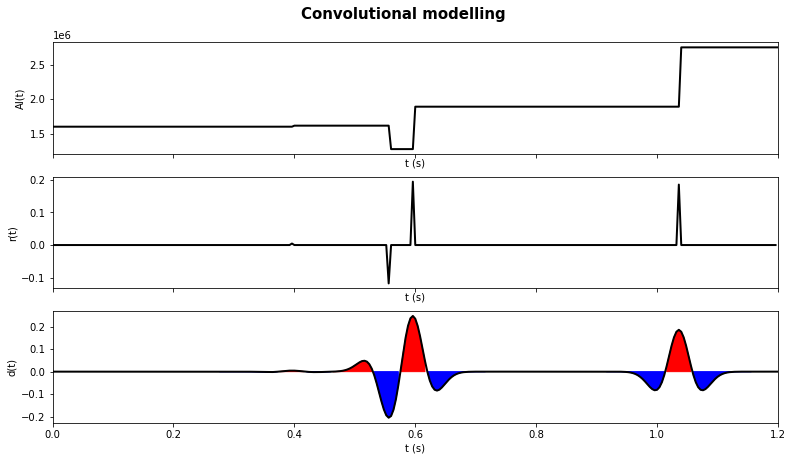

In [4]:
seismic, reflectivity = convolutional_modelling(ai, t, wav, wavcenter)

fig, axs = plt.subplots (3, 1, sharex=True, figsize=(13, 7))
fig.suptitle('Convolutional modelling', y=0.95, fontsize=15, fontweight='bold')
axs[0].plot(t, ai, 'k', lw=2)
axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('AI(t)');
axs[1].plot(t[:-1], reflectivity, 'k', lw=2)
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('r(t)');
axs[2].plot(t, seismic, 'k', lw=2)
axs[2].fill_between(t, 0, seismic, where=(seismic > 0), color='r')
axs[2].fill_between(t, 0, seismic, where=(seismic < 0), color='b')
axs[2].set_xlabel('t (s)')
axs[2].set_ylabel('d(t)')
axs[2].set_xlim(0, t[-1]);

You can now change the frequency content of the wavelet and observe how the interference pattern at the thin layer changes.

**Exercise**: Modify the convolution modelling code and create a wedge model as in Figure below. Remember that the convolutional modelling is purely 1D, so you will simply need to repeat it many times for each horizontal location in the model below and ultimately produce a seismic image that we generally refer to as *post-stack seismic data*.

![Wedge model](wedgemodel.png)

We apply now the same modelling code to the Smehaia 32/2-1 well that we have already used in our previous lab.

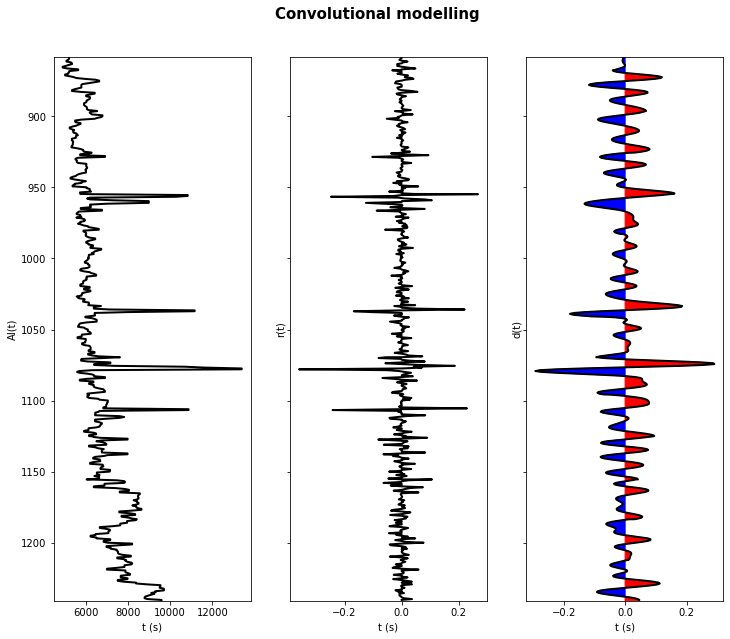

In [5]:
# Read Logs
logs = lasio.read('../data/32_2-1')

# Select depth axis and AI profile and apply a median filter
z, ai = logs.index[430:-50], medfilt(logs['AI'][430:-50], 3)

# Compute reflectivity and data
seismic, reflectivity = convolutional_modelling(ai, logs.index, wav, wavcenter)

fig, axs = plt.subplots (1, 3, sharey=True, figsize=(12, 10))
fig.suptitle('Convolutional modelling', y=0.95, fontsize=15, fontweight='bold')
axs[0].plot(ai, z, 'k', lw=2)
axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('AI(t)');
axs[1].plot(reflectivity, z[:-1], 'k', lw=2)
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('r(t)');
axs[2].plot(seismic, z, 'k', lw=2)
axs[2].fill_betweenx(z, 0, seismic, where=(seismic > 0), color='r')
axs[2].fill_betweenx(z, 0, seismic, where=(seismic < 0), color='b')
axs[2].set_xlabel('t (s)')
axs[2].set_ylabel('d(t)')
axs[2].set_ylim(z[-1], z[0]);

## AVO modelling

Let's try now to move a step further and model the seismic response as function of the angle of incidence. For this exercise we need to use the solution of the Lamb's problem, which we saw in class. This is the well known Zoeppritz equation. Alongside the Zoeppritz equation, which is cumbersome to implement and nonlinearly related to the elastic parameters of the Earth, we will also consider two popular linearized approximations:

- Aki-Richards approximation (eq 16 in https://wiki.seg.org/wiki/AVO_equations);
- Fatti approximation (https://www.subsurfwiki.org/wiki/Fatti_equation).

We will start with a simple interface bounded by two half-infinite layers with known properties.

In [6]:
def akirichards(vp1, vs1, rho1, vp2, vs2, rho2, theta1):
    theta1 = np.radians(theta1)
    # Snell's law
    theta2 = np.arcsin(vp2 / vp1 * np.sin(theta1))
    
    # Parameter differences and averages 
    drho = rho2-rho1
    dvp = vp2-vp1
    dvs = vs2-vs1
    theta = theta1 # alternatively we can use the average of the incident and transmission angle, (theta1+theta2)/2.0
    rho = (rho1+rho2)/2.0
    vp = (vp1+vp2)/2.0
    vs = (vs1+vs2)/2.0
    vsvp = vs1 / vp1
    
    # Compute the three terms of Aki Richards equation
    term1 = 1. / (2. * np.cos(theta) ** 2) * dvp / vp
    term2 = -4. * vsvp ** 2 * np.sin(theta) ** 2 * dvs / vs
    term3 = 0.5 * (1 - 4 * vsvp ** 2 * np.sin(theta) ** 2) * drho / rho

    return term1 + term2 + term3

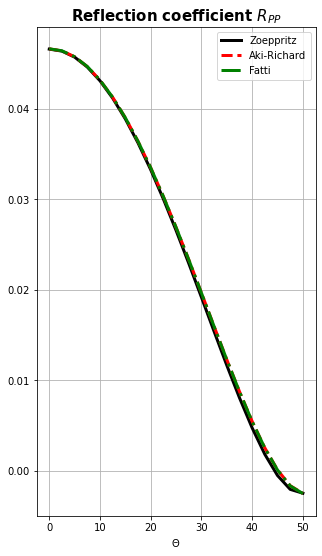

In [7]:
# Define medium
vp1, vs1, rho1 = 2200., 1300., 2000  # upper medium
vp0, vs0, rho0 = 2300., 1400., 2100  # lower medium

# Define angles
ntheta = 21
thetamin, thetamax = 0, 50
theta = np.linspace(thetamin, thetamax, ntheta)

# Create composite parameters
ai0, si0, vpvs0 = vp0*rho0, vs0*rho0, vp0/vs0
ai1, si1, vpvs1 = vp1*rho1, vs1*rho1, vp1/vs1

# Zoeppritz
rpp_zoep = zoeppritz_pp(vp1, vs1, rho1, vp0, vs0, rho0,  theta)

# Aki Richards
rpp_aki = akirichards(vp1, vs1, rho1, vp0, vs0, rho0, theta)

# Aki Richards (using PyLops modelling)
#rvp = np.log(vp0) - np.log(vp1)
#rvs = np.log(vs0) - np.log(vs1)
#rrho = np.log(rho0) - np.log(rho1)
#G1, G2, G3 = akirichards(theta, vs1/vp1)
#rpp_aki = G1*rvp + G2*rvs + G3*rrho

# Fatti (using PyLops modelling)
rai = np.log(ai0) - np.log(ai1)
rsi = np.log(si0) - np.log(si1)
rrho = np.log(rho0) - np.log(rho1)
G1, G2, G3 = fatti(theta, vs1/vp1)
rpp_fatti = G1*rai + G2*rsi + G3*rrho

plt.figure(figsize=(5, 9))
plt.plot(theta, rpp_zoep, 'k', lw=3, label='Zoeppritz')
plt.plot(theta, rpp_aki, '--r', lw=3, label='Aki-Richard')
plt.plot(theta, rpp_fatti, '-.g', lw=3, label='Fatti')
plt.xlabel(r'$\Theta$')
plt.title(r'Reflection coefficient $R_{PP}$', fontsize=15, fontweight='bold')
plt.grid()
plt.legend();

It is well known that these approximations are good at small angles of incidence and for mild changes in the elastic parameters. Try now to modify the elastic properties of the bottom layer and evaluate when these approximations start to deviate from the Zoeppritz equation.

**Exercise:** modify the `akirichards` routine to model the AVO response for the vertical profiles of (VP,VS,Rho) created above. Finally, convolve the AVO response with our wavelet ``wav`` to produce the so-called *pre-stack seismic data* or *AVO gather*.

You can use the code below to benchmark your results, but you will need to provide a function yourself along the lines of the one we implemented together above.

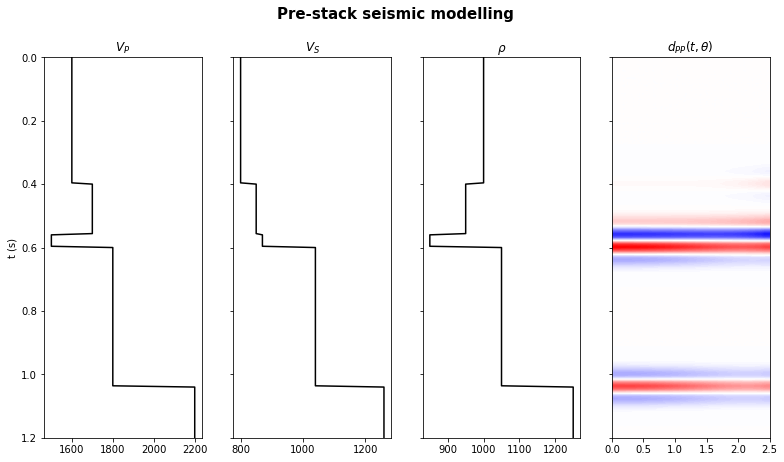

In [8]:
PPop = PrestackLinearModelling(wav, theta, vsvp=vs/vp, nt0=nt, linearization='akirich')
m = np.stack((np.log(vp), np.log(vs), np.log(rho)), axis=1)

d = PPop * m.ravel()
d = d.reshape(nt, ntheta)

fig, axs = plt.subplots (1, 4, sharey=True, figsize=(13,7))
fig.suptitle('Pre-stack seismic modelling', fontsize=15, fontweight='bold')
axs[0].plot(vp,  t, 'k')
axs[0].set_ylabel('t (s)')
axs[0].set_title(r'$V_P$')
axs[1].plot(vs,  t, 'k')
axs[1].set_title(r'$V_S$')
axs[2].plot(rho, t, 'k')
axs[2].set_title(r'$\rho$')
axs[3].imshow(d, cmap='seismic', extent=(theta[0], theta[1], t[-1], t[0]), 
              vmin=-0.5, vmax=0.5)
axs[3].set_title(r'$d_{PP}(t, \theta)$')
axs[3].axis('tight');

To conclude we look at the associate inverse problem, generally called *pre-stack seismic inversion*. Given the AVO gather in the figure above and a smooth version of the $(V_P,V_S,\rho)$ profiles, can we retrieve the correct model of the subsurface?

In [9]:
# Create smooth model
nsmooth = 50
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)

# Create residual data
d0 = PPop * mback.flatten()
dr = d.flatten() - d0

# Invert model
minv = NormalEquationsInversion(PPop, [], dr, epsI=1e-4, **dict(maxiter=300))
minv = minv.reshape(nt, 3)
minv = mback + minv

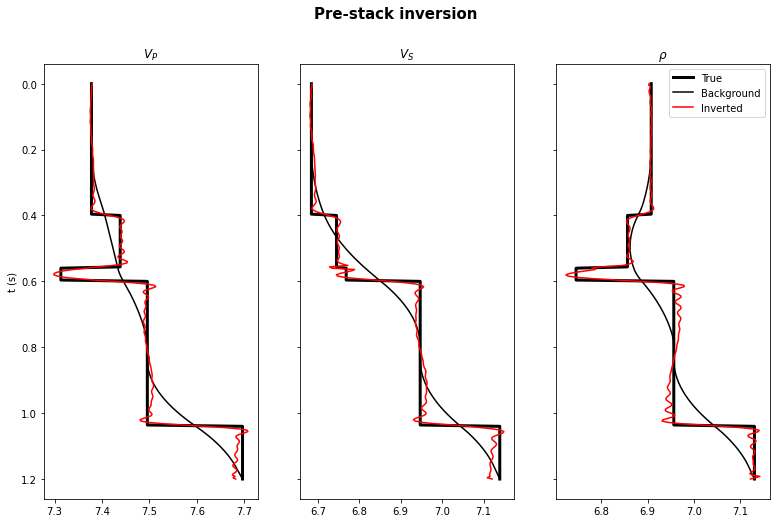

In [10]:
fig, axs = plt.subplots (1, 3, sharey=True, figsize=(13, 8))
fig.suptitle('Pre-stack inversion', fontsize=15, fontweight='bold')
axs[0].plot(m[:, 0],  t, 'k', lw=3)
axs[0].plot(mback[:, 0],  t, 'k')
axs[0].plot(minv[:, 0],  t, 'r')
axs[0].set_ylabel('t (s)')
axs[0].set_title(r'$V_P$')
axs[1].plot(m[:, 1],  t, 'k', lw=3)
axs[1].plot(mback[:, 1],  t, 'k')
axs[1].plot(minv[:, 1],  t, 'r')
axs[1].set_title(r'$V_S$')
axs[2].plot(m[:, 2],  t, 'k', lw=3, label='True')
axs[2].plot(mback[:, 2],  t, 'k', label='Background')
axs[2].plot(minv[:, 2],  t, 'r', label='Inverted')
axs[2].set_title(r'$\rho$')
axs[2].legend()
axs[2].invert_yaxis();

That's it! We have learned how to model post- and pre-stack seismic data using the theory developed in class based on the interaction of a plane wave at an interface. 

Finally we have inverted our AVO gather for the underlying elastic properties: this process lies at the core of the field of seismic reservoir charactherization as we will discuss in future classes.